#### Bulk Assign Managed Attributes
This notebook demonstrates an approach to bulk updating entities with managed attributes, but could be applied to other types of updates.  This example includes code to synthetically create a number of entities and remove them for the purposes of scale testing.

#### Configuration

In [ ]:
import yaml, requests, json

# Open the config file to read the client details
with open("../config/config.yaml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

client_id = config[0]['client_id']
client_secret = config[0]['client_secret']
tenant_id = config[0]['tenant_id']
purview_account_name = config[0]['purview_account_name']
scope = f"{config[0]['resource']}/.default"
purview_endpoint = f"https://{purview_account_name}.purview.azure.com"
authority = f"https://login.microsoftonline.com/{tenant_id}"

access_token = ""

#### Functions

In [ ]:
# Function to construct header for HTTP requests
# Parameters:  None
# Returns: Dictionary with header information
##
def getHeaders():
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': 'application/json'
    }
    return headers;

In [ ]:
# Function to search for all entities in a given Collection.  Returns a searchresult object
# Parameters:  
#   limit:          Batch size to return (50-1000)
#   collection_id:  Collection ID to search
# Returns:  Ordered dict object with Search Results sorted by guid (https://learn.microsoft.com/en-us/rest/api/purview/catalogdataplane/discovery/query?tabs=HTTP#searchresult)
##
def queryCollection(limit, collection_id):

    search_uri = f"{purview_endpoint}/catalog/api/search/query?api-version=2022-03-01-preview"
    payload = json.dumps({
        "keywords": None,
        "limit": limit,
        "filter": {
            "collectionId": collection_id
        }
    })

    response = json.loads(requests.request("POST", search_uri, data=payload, headers=getHeaders()).content)
    return response

In [ ]:
# Function to search catalog for a given fqdn pattern and a guid.  Returns a searchresult object
# Parameters:  
#   limit:   Batch size to return (50-1000)
#   collection_id:    The collection to search
#   guid:    search offset (will filter for results greater than this)
# Returns:  Ordered dict object with Search Results sorted by guid (https://learn.microsoft.com/en-us/rest/api/purview/catalogdataplane/discovery/query?tabs=HTTP#searchresult)
##
def queryCollection(limit, collection_id, guid):

    search_uri = f"{purview_endpoint}/catalog/api/search/query?api-version=2022-03-01-preview"
    payload = json.dumps({
        "keywords": None,
        "limit": limit,
        "filter": {
            "and": [
                {
                    "collectionId": collection_id
                },
                {
                    "id": {
                        "operator": "gt",
                        "value": guid
                    }

                }
            ]
        },
        "offset": 0,
        "limit": limit,
        "orderby": [{
            "id": "asc"
        }]
    })

    response = json.loads(requests.request("POST", search_uri, data=payload, headers=getHeaders()).content)
    return response

#### OAuth Login
Perform Authentication using the Microsoft Authentication Library and get a bearer token for subsequent API calls

In [ ]:
from msal import ConfidentialClientApplication

app = ConfidentialClientApplication(client_id, authority=authority, client_credential=client_secret)
result = app.acquire_token_for_client(scopes=scope)

access_token = result['access_token']

#### Intial Setup
Create a collection and populate it with some assets

In [ ]:
# Initial setup:  Create the collection and keep a reference to it
collection_id = "api-bulk-glossary"
collection_friendly_name = "API Bulk Glossary"

# Create a collection for the assets
collection_uri = f"{purview_endpoint}/account/collections/{collection_id}?api-version=2019-11-01-preview"
payload = json.dumps({
    "friendlyName": collection_friendly_name,
    "parentCollection": {
        "referenceName": purview_account_name
    }
})
response = json.loads(requests.request("PUT", collection_uri, headers=getHeaders(), data=payload).content)

First we need to create a new type definition for the managed attribute.  In this example, we'll create a  managed attribute to define the Data Residency details such as the cloud region teh data is stored in and if the data is restricted to just that region.

In [ ]:
# Create an enumerator for the region choices we wat to use in the managed attribute
typedef_uri = f"{purview_endpoint}/catalog/api/atlas/v2/types/typedefs?api-version=2022-08-01-preview"
payload = json.dumps({
    "enumDefs": [
        {
            "name": "ATTRIBUTE_ENUM_REGION_CHOICES",
            "description": "Cloud Regions",
            "elementDefs": [
                {  "value": "eastus", "ordinal": 0 },
                {  "value": "westus", "ordinal": 1 },
                {  "value": "northeurope", "ordinal": 2 },
                {  "value": "westeurope", "ordinal": 3 },
                {  "value": "uksouth", "ordinal": 4 },
                {  "value": "ukwest", "ordinal": 5 }
            ]
        }
    ]
})

response = json.loads(requests.request("POST", typedef_uri, headers=getHeaders(), data=payload).content)
print(response)

In [ ]:
# Create the managed attribute type definition
typedef_uri = f"{purview_endpoint}/catalog/api/atlas/v2/types/typedefs?api-version=2022-08-01-preview"
payload = json.dumps({
    "businessMetadataDefs": [
        {
            "name": "Data Residency",
            "description": "Information about the data residency of the asset",
            "attributeDefs": [
                {
                    "name": "Cloud Region",
                    "typeName": "ATTRIBUTE_ENUM_REGION_CHOICES",
                    "isOptional": True,
                    "options": { 
                        "applicableEntityTypes": "[\"DataSet\"]",
                        "isDisabled": False
                    }
                },
                {
                    "name": "Cross Border Restricted",
                    "typeName": "boolean",
                    "isOptional": True,
                    "options": { 
                        "applicableEntityTypes": "[\"DataSet\"]",
                        "isDisabled": False
                    }
                }
            ]
        }
    ]
})

response = json.loads(requests.request("POST", typedef_uri, headers=getHeaders(), data=payload).content)
print(response)

Once the above Managed Attribute Type has been created, you should see this in the Data Map and it can be added to all Enties of type 'Dataset' as well as any sub-types:

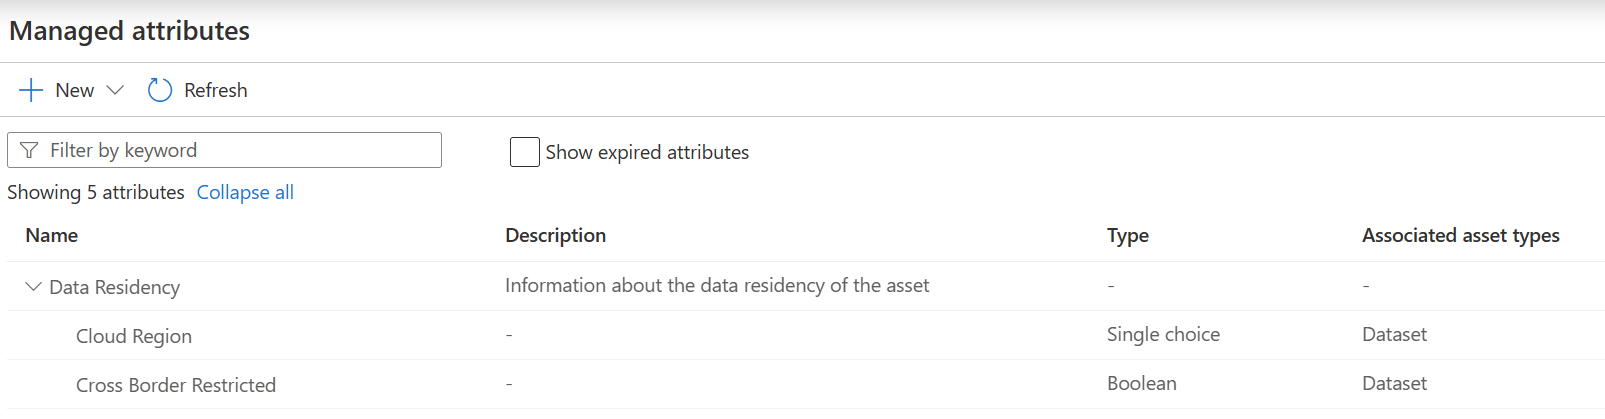
 
Now let's create some sample entities to use for the bulk assignment operation.

In [ ]:

fqdn_prefix = "mssql://test-db.database.windows.net/test-server/test-database/test-schema/"
num_entities_to_create = 1000        # Define the number of entities to create (creates Azure SQL tables)
entities = []                         # Initialise a list to store each entity JSON

# Loop and create the required asset definitions
i = 1
while i <= num_entities_to_create:

    id = str(i).zfill(5)
    entity = {
      "typeName": "azure_sql_table",
      "guid": f"-{i}",
      "attributes": {
        "name": f"Table {id}", 
        "qualifiedName": f"{fqdn_prefix}/Test-Table-{id}",
        "description": f"Bulk created asset Test-Table-{id}"
      }
    }
    entities.append(entity)
    i += 1

# Define the (collection) bulk create or update URI and push the JSON payload to it
uri = f'{purview_endpoint}/catalog/api/collections/{collection_id}/entity/bulk?api-version=2022-03-01-preview'
payload = json.dumps({
  "referredEntities": {},
  "entities": entities
})
response = json.loads(requests.request("POST", uri, headers=getHeaders(), data=payload).content)

#### Generate the Business Metadata
We could have created the business metadata alongside the objects we created above, but if we want to bulk update some assets post-creation, the most efficient mechanism is via a file upload.  There are 2 API calls to help here, the first provides the template, the second can then be used to upload a populated template.  Let's start with the template download.

In [ ]:
# Call the URI and get the reponse (a comma-separated list of field names)
template_uri = f"{purview_endpoint}/catalog/api/atlas/v2/entity/businessmetadata/import/template"
response = requests.request("GET", template_uri, headers=getHeaders()).content

# Parse the response to get the filed names as a list
field_names = response.decode("utf-8").split("\r\n")[0].split(",")


Now that we have the file template we need to populate it.  To do this we can execute a search to get the entities we are interested in and write the relevant details to a local file.

In [ ]:
import csv, math

batch_size = 500

filename = "bulk-managed-attributes.csv"
file_headers = field_names
file_rows = []

# Create a new file and add the header row (see previous cell)
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(file_headers)


    # Get the first batch (search using the collection and using zero guid, effectively starting from the first ordered guid)
    results = queryCollection(batch_size, collection_id, "0")
    num_results = len(results.get("value"))

    # Get the total number of results from the search
    total_num_of_entities = int(results.get("@search.count"))
    print(f"Total number of entities in collection: {total_num_of_entities}")

    # Calculate the number of batches needed
    number_of_batches = total_num_of_entities / batch_size
    number_of_batches = math.ceil(number_of_batches)

    # Loop through each batch 
    for batch in range(int(number_of_batches)):
        print(f"Processing batch {batch+1} of {int(number_of_batches)}")

        # Get the list of guids from the current query
        for entities in results['value']:
            this_guid = {"guid": f"{entities['id']}"}

            file_rows.append([entities['entityType'], entities['qualifiedName'],"Data Residency.Cloud Region", "uksouth", "qualifiedName"])
            file_rows.append([entities['entityType'], entities['qualifiedName'],"Data Residency.Cross Border Restricted", "TRUE", "qualifiedName"])

        # Write out this batch of rows to the file and clear the list    
        csvwriter.writerows(file_rows)
        file_rows = []

        # Query for the next batch passing in the last guid processed
        results = queryCollection(batch_size, collection_id, this_guid['guid'])

Now that we have our generated file we can use this in the Managed Attributes import metadata call.

In [ ]:
# Call the URI and get the reponse (a comma-separated list of field names)
import_uri = f"{purview_endpoint}/catalog/api/atlas/v2/entity/businessmetadata/import"

payload = {}

# Define a tuple with the file to upload
files = [
    ('file', (filename, open(filename, 'rb'), 'text/csv'))
    ]

# Construct the header but remove the Content-Type
headers = getHeaders()
headers.pop('Content-Type')

response = requests.request("POST", import_uri, headers=headers, data=payload, files=files)

print(response.text)

#### Cleanup
Delete the assets that were created, the Managed Attribute Types, enumerators, and the collection

In [ ]:
num_entities_for_deletion = 1
delete_batch_size = 100

while num_entities_for_deletion > 0:
  entities_for_deletion = queryCollection(delete_batch_size, collection_id, 0)
  num_entities_for_deletion = entities_for_deletion['@search.count']

  print(f"{num_entities_for_deletion} remaining for deletion")
  
  delete_uri = f"{purview_endpoint}/catalog/api/atlas/v2/entity/bulk?"
  for i in entities_for_deletion['value']:
    delete_uri = delete_uri + f"guid={i['id']}&"

  json.loads(requests.request("DELETE", delete_uri[:-1], headers=getHeaders()).content)

In [ ]:
#Delete the collection
delete_uri = f"{purview_endpoint}/collections/{collection_id}?api-version=2019-11-01-preview"
headers = getHeaders()
requests.request("DELETE", delete_uri, headers=headers)

In [ ]:
#Delete the Managed Attribute Type
delete_uri = f"{purview_endpoint}/catalog/api/atlas/v2/types/typedef/name/Data%20Residency"
headers = getHeaders()
requests.request("DELETE", delete_uri, headers=headers)

In [ ]:
#Delete the enumerator
delete_uri = f"{purview_endpoint}/catalog/api/atlas/v2/types/typedef/name/ATTRIBUTE_ENUM_REGION_CHOICES"
headers = getHeaders()
requests.request("DELETE", delete_uri, headers=headers)